In [1]:
from pathlib import Path
from train_ppo import PPOTrainingConfig, PPOTrainer, run_sinr_evaluation, RewardWeights
import pandas as pd, matplotlib.pyplot as plt
from stable_baselines3 import PPO 
from train_ppo import FlyingBaseStationEnv
from stable_baselines3.common.monitor import Monitor
import numpy as np
import plotly.express as px
import pandas as pd

from pathlib import Path
from matplotlib.colors import ListedColormap


In [2]:
def next_run_dir(root: Path, stem: str = "run"):
    root.mkdir(exist_ok=True)
    idx = 1
    while True:
        candidate = root / f"{stem}_{idx:03d}"
        if not candidate.exists():
            candidate.mkdir()
            return candidate
        idx += 1
        
def latest_run_path(root: Path, stem: str = "run"):
    candidates = sorted(root.glob(f"{stem}_*"))
    if not candidates:
        raise FileNotFoundError("No saved runs.")
    return candidates[-1]

def run_dir_path(root: Path, run_id: int, stem: str = "run") -> Path:
    path = root / f"{stem}_{run_id:03d}"
    if not path.exists():
        raise FileNotFoundError(f"{path} not found")
    return path

def run_dir_by_name(root: Path, name: str) -> Path:
    path = root / name
    if not path.exists():
        raise FileNotFoundError(f"{path} not found")
    return path  

In [3]:
repo_root = Path("/Users/fadya/Documents/MATLAB/GA_github/genetic-algorithm-optimization/genetic-algorithm-optimization")
runs_dir = repo_root / "ppo_runs"
monitor_path = repo_root / "ppo_logs" / "monitor.csv"

max_episode_steps = 50

In [17]:
config = PPOTrainingConfig(
    quadriga_path="/Users/fadya/Documents/MATLAB/quadriga_src",
    repo_path=str(repo_root),
    total_timesteps = 4_000,  
    max_episode_steps = max_episode_steps,
    ent_coef = 0.3,
    action_scale = 0.4,
    learning_rate = 1e-4
)
trainer = PPOTrainer(config)
try:
    trainer.train()
    run_dir = next_run_dir(repo_root / "ppo_runs")
    trainer.save(run_dir / "ppo_fbs_agent")
finally:
    trainer.close()


# {'learning_rate': 0.0001,
#  'n_steps': 2048,
#  'batch_size': 64,
#  'gamma': 0.99,
#  'gae_lambda': 0.95,
#  'clip_range': FloatSchedule(ConstantSchedule(val=0.2)),
#  'ent_coef': 0.2,
#  'vf_coef': 0.5,
#  'max_grad_norm': 0.5,
#  'policy_kwargs': {}}

Using cpu device
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | 3.05e+04 |
| time/              |          |
|    fps             | 1        |
|    iterations      | 1        |
|    time_elapsed    | 1774     |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 50          |
|    ep_rew_mean          | 3.05e+04    |
| time/                   |             |
|    fps                  | 1           |
|    iterations           | 2           |
|    time_elapsed         | 3542        |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.000724246 |
|    clip_fraction        | 4.88e-05    |
|    clip_range           | 0.2         |
|    entropy_loss         | -7.11       |
|    explained_varia

<Axes: xlabel='t'>

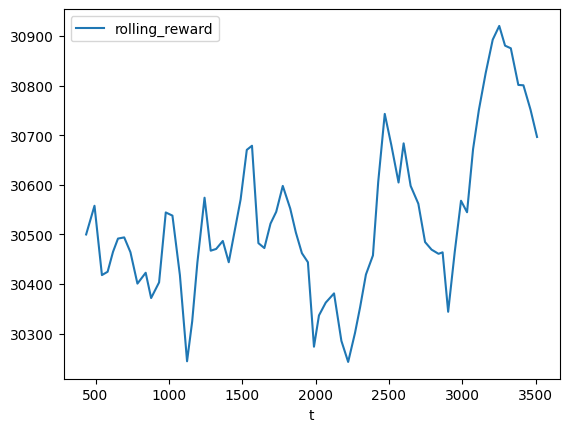

In [18]:
df = pd.read_csv(monitor_path, comment="#")
df['rolling_reward'] = df['r'].rolling(window=10).mean()
df.plot(x='t', y='rolling_reward')

### Testing

In [29]:
# target_dir = latest_run_path(runs_dir)
run_name = "run_000_cand3_ps_mark"
target_dir = run_dir_by_name(runs_dir, run_name)
print(f"Loading model from: {target_dir}")

max_episode_steps_test = 100

model = PPO.load(target_dir / "ppo_fbs_agent")
env = FlyingBaseStationEnv(
    repo_path = str(repo_root), 
    quadriga_path = "/Users/fadya/Documents/MATLAB/quadriga_src",
    max_episode_steps = max_episode_steps_test,
    action_scale = 0.3
)
mbs_x = np.array(env.mbs_x).ravel()
mbs_y = np.array(env.mbs_y).ravel()

# comment if randomizing the reset state
custom_state = np.array([500.0, 1200.0, 100.0, 7, 0.0], dtype=np.float32) 
obs, _ = env.reset()
env._state = custom_state.copy()  
obs = env._state.copy()

# use if evaluating with regular environment random state 
# obs, _ = env.reset()

states = [obs.copy()]
rewards, infos = [], []
for step in range(max_episode_steps_test):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, term, trunc, info = env.step(action)
    states.append(obs.copy())
    rewards.append(reward)
    infos.append(info)
    if term or trunc:
        break


Loading model from: /Users/fadya/Documents/MATLAB/GA_github/genetic-algorithm-optimization/genetic-algorithm-optimization/ppo_runs/run_000_cand3_ps_mark


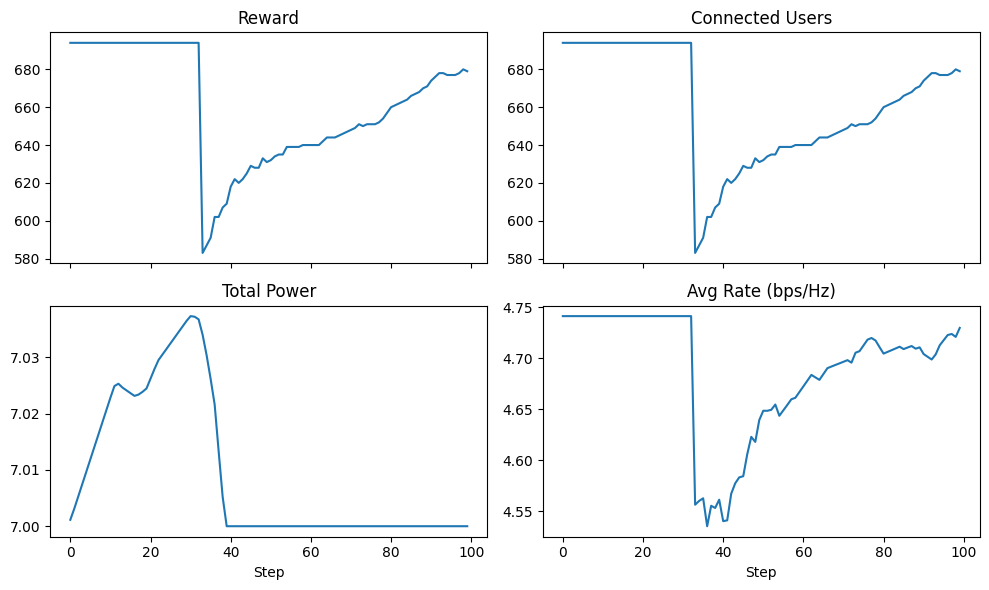

In [30]:
df = pd.DataFrame(infos)
df["reward"] = rewards
states = pd.DataFrame(states, columns=["x","y","height","power","power_status"])

fig, axes = plt.subplots(2, 2, figsize=(10,6), sharex=True)
df["reward"].plot(ax=axes[0,0], title="Reward")
df["total_connected"].plot(ax=axes[0,1], title="Connected Users")
df["total_power"].plot(ax=axes[1,0], title="Total Power")
df["avg_rate"].plot(ax=axes[1,1], title="Avg Rate (bps/Hz)")
axes[1,0].set_xlabel("Step")
axes[1,1].set_xlabel("Step")
plt.tight_layout()

In [31]:
hyperparams = {
    "learning_rate": model.learning_rate,
    "n_steps": model.n_steps,
    "batch_size": model.batch_size,
    "gamma": model.gamma,
    "gae_lambda": model.gae_lambda,
    "clip_range": model.clip_range,
    "ent_coef": model.ent_coef,
    "vf_coef": model.vf_coef,
    "max_grad_norm": model.max_grad_norm,
    "policy_kwargs": model.policy_kwargs,
}
hyperparams

{'learning_rate': 0.0001,
 'n_steps': 2048,
 'batch_size': 64,
 'gamma': 0.99,
 'gae_lambda': 0.95,
 'clip_range': FloatSchedule(ConstantSchedule(val=0.2)),
 'ent_coef': 0.3,
 'vf_coef': 0.5,
 'max_grad_norm': 0.5,
 'policy_kwargs': {}}

In [32]:
states

,x,y,height,power,power_status
0,500.000000,1200.000000,100.000000,7.000000,0.0
1,499.322357,1181.857056,99.412338,7.001141,0.0
2,498.383575,1163.337646,98.697426,7.003143,0.0
3,497.294434,1144.793457,97.929131,7.005325,0.0
4,496.200836,1126.249634,97.159500,7.007511,0.0
...,...,...,...,...,...
96,339.258942,0.000000,40.980091,7.000000,1.0
97,334.194244,0.000000,40.452133,7.000000,1.0
98,329.095428,0.000000,39.923973,7.000000,1.0
99,323.961975,0.000000,39.395599,7.000000,1.0


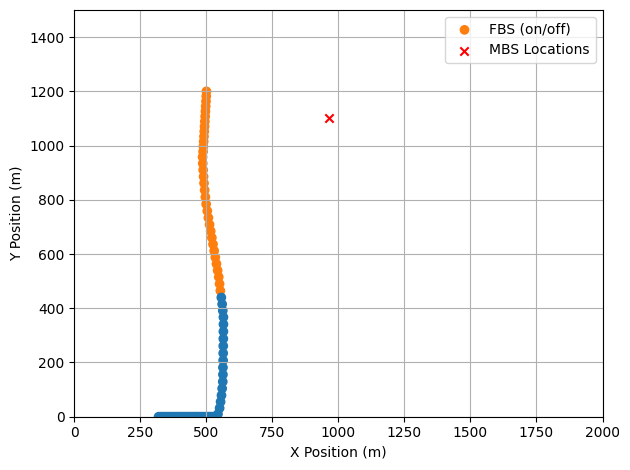

In [33]:
power_status = states["power_status"]
cmap = ListedColormap(["tab:orange", "tab:blue"])  # off → orange, on → blue
colors = cmap(power_status.astype(int))

plt.figure()
plt.scatter(states["x"], states["y"], c=colors, label="FBS (on/off)")
plt.scatter(mbs_x, mbs_y, c="red", marker="x", label="MBS Locations")
plt.legend()
plt.xlabel("X Position (m)")
plt.ylabel("Y Position (m)")
plt.xlim(0, env.W)
plt.ylim(0, env.H)
plt.grid(True)
plt.tight_layout()

In [34]:
mbs_df = pd.DataFrame({"x": mbs_x, "y": mbs_y, "type": "MBS"})
states_df = states.copy()
states_df["type"] = states_df["power_status"].map({0: "FBS Off", 1: "FBS On"})

fig_states = px.scatter(
    states_df,
    x="x",
    y="y",
    color="type",
    symbol="type",
    title="FBS Trajectory (Plotly)",
    labels={"x": "X Position (m)", "y": "Y Position (m)"},
)
fig_mbs = px.scatter(
    mbs_df,
    x="x",
    y="y",
    color="type",
    symbol="type",
)

for trace in fig_mbs.data:
    fig_states.add_trace(trace)

fig_states.update_layout(
    xaxis=dict(range=[0, env.W]),
    yaxis=dict(range=[0, env.H]),
    legend=dict(title=""),
)

In [35]:
states

,x,y,height,power,power_status
0,500.000000,1200.000000,100.000000,7.000000,0.0
1,499.322357,1181.857056,99.412338,7.001141,0.0
2,498.383575,1163.337646,98.697426,7.003143,0.0
3,497.294434,1144.793457,97.929131,7.005325,0.0
4,496.200836,1126.249634,97.159500,7.007511,0.0
...,...,...,...,...,...
96,339.258942,0.000000,40.980091,7.000000,1.0
97,334.194244,0.000000,40.452133,7.000000,1.0
98,329.095428,0.000000,39.923973,7.000000,1.0
99,323.961975,0.000000,39.395599,7.000000,1.0


In [36]:
env.close()

## only use if evaluating single step

In [37]:
target_dir = latest_run_path(runs_dir)
# run_name = "run_000_cand_20k_100"
# target_dir = run_dir_by_name(runs_dir, run_name)
print(f"Loading model from: {target_dir}")

model = PPO.load(target_dir / "ppo_fbs_agent")
env = FlyingBaseStationEnv(
    repo_path = str(repo_root), 
    quadriga_path = "/Users/fadya/Documents/MATLAB/quadriga_src",
    max_episode_steps = 1
)


# 318.793396	0.000000	38.866997	7.000000	
state = np.array([318.79, 0.0, 38.87, 7.0, 1.0], dtype=np.float32)
total_connected, total_power, avg_rate, fbs_conn, mbs_conn, user_positions = run_sinr_evaluation(
    env._eng,
    env.antenna_fbs,
    env.antenna_mbs,
    env.mbs_cache,
    state[:4],
    state[4],
    env.area_bounds,
    env.num_users,
    env.sinr_threshold,
    env.contains_mbs,
    env.mbs_x,
    env.mbs_y,
    env.mbs_height,
    env.mbs_power,
)

print(env.mbs_x, env.mbs_y)

weights = env.reward_weights
reward = (
    weights.beta_connected * total_connected
    - weights.gamma_power * total_power
    + weights.delta_avg_rate * avg_rate
)
info = {
    "total_connected": total_connected,
    "total_power": total_power,
    "avg_rate": avg_rate,
    "fbs_connected": fbs_conn,
    "mbs_connected": mbs_conn,
    "user_positions": user_positions
}

print(reward, {"total_connected": total_connected, "total_power": total_power, "avg_rate": avg_rate})
env.close()

Loading model from: /Users/fadya/Documents/MATLAB/GA_github/genetic-algorithm-optimization/genetic-algorithm-optimization/ppo_runs/run_011
[[966.0254037844385]] [[1100.0]]
679.0 {'total_connected': 679, 'total_power': 7.0, 'avg_rate': 4.729839436367812}
